#  Two-Class image categorization with STDP/R-STDP
Here, we provide a brief tutorial on designing, training, and evaluating a two-layer spiking neural network (SNN). 
The network in this tutorial has the following specifications:
 - **Input Images**: Grayscale images in single scale
 - **Layer S1**: 4 Gabor filter in different orientations, conversion to spike-wave tensor
 - **Layer C1**: Local pooling
 - **Layer S2**: Trainable convolutional layer employing STDP or R-STDP

The target task is the categorization of COVID and Non COVID images taken from the COVID CT Scan dataset. Here, we down-scaled images by half for the sake of a faster execution .



## 0. Requirements
In order to run this tutorial or use SpykeTorch in general, there are several things that you need to install on your machine. To make the life easier, we recommend installing [**Anaconda**](https://www.anaconda.com/distribution/). It is a Python distribution that includes all of the scientific packages and leaves no worries for not only this tutorial but also other SpykeTorch's scripts.

SpykeTorch is developed based on **PyTorch**. Thus, in addition to Anaconda, you must install PyTorch package. Through [PyTorch's web-page](https://pytorch.org/) you can easily find the install script based on the configuration of the machine you have.

When you are done with the requirements, you can clone this repository and start using this tutorial via Jupyter. To this end, open a terminal at the repo's location and enter this command: <br> `jupyter notebook` <br> After a few seconds, a new tab in your default browser will be opened and you can select this notebook to work with.

## 1. Layer S1
Implementation of layer S1 consists of loading images and applying series of transformations to convert an image into spike-wave tensor. We will load images with the help of Torchvision's `ImageFolder` dataset and PyTorch's `DataLoader`, but first, we need to prepare the image transform.

The whole pipeline of image transformation is as follows:<br> image >> grayscale image >> PyTorch's 3D tensor >> 4D tensor (time dimension) >> Gabor filters >> lateral inhibition >> intencity-to-latency encoding.

`SpykeTorch.utils` provides `Filter` class which is suitable for applying different filter kernels on a 4D input tensor. Here, we create a `Filter` object by providing a list of 4 Gabor filter kernels. We involve negative edges into our computations by setting `use_abs` to `True`.

In [ ]:
!git clone https://github.com/miladmozafari/SpykeTorch.git
%cd SpykeTorch/

/content/SpykeTorch


CT_scan dataset

In [ ]:
!wget "https://github.com/UCSD-AI4H/COVID-CT/raw/master/Images-processed/CT_COVID.zip"
!wget "https://github.com/UCSD-AI4H/COVID-CT/raw/master/Images-processed/CT_NonCOVID.zip"

--2020-11-08 06:08:04--  https://github.com/UCSD-AI4H/COVID-CT/raw/master/Images-processed/CT_COVID.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/UCSD-AI4H/COVID-CT/master/Images-processed/CT_COVID.zip [following]
--2020-11-08 06:08:04--  https://raw.githubusercontent.com/UCSD-AI4H/COVID-CT/master/Images-processed/CT_COVID.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47929914 (46M) [application/zip]
Saving to: ‘CT_COVID.zip’

CT_COVID.zip        100%[===================>]  45.71M   243MB/s    in 0.2s    

2020-11-08 06:08:04 (243 MB/s) - ‘CT_COVID.zip’ saved [47929914/47929914]

--2020-1

In [ ]:
!unzip /content/CT_COVID.zip
!unzip /content/CT_NonCOVID.zip

Archive:  /content/CT_COVID.zip
   creating: CT_COVID/
  inflating: CT_COVID/2020.03.01.20029769-p21-73_1%1.png  
   creating: __MACOSX/
   creating: __MACOSX/CT_COVID/
  inflating: __MACOSX/CT_COVID/._2020.03.01.20029769-p21-73_1%1.png  
  inflating: CT_COVID/Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png  
  inflating: __MACOSX/CT_COVID/._Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png  
  inflating: CT_COVID/2020.03.12.20034686-p17-91-4.png  
  inflating: __MACOSX/CT_COVID/._2020.03.12.20034686-p17-91-4.png  
  inflating: CT_COVID/2020.02.25.20021568-p24-111%8.png  
  inflating: __MACOSX/CT_COVID/._2020.02.25.20021568-p24-111%8.png  
  inflating: CT_COVID/2020.03.13.20035212-p23-153.png  
  inflating: __MACOSX/CT_COVID/._2020.03.13.20035212-p23-153.png  
  inflating: CT_COVID/2020.03.21.20040691-p18-6-6.png  
  inflating: __MACOSX/CT_COVID/._2020.03.21.20040691-p18-6-6.png  
  inflating: CT_COVID/2020

In [ ]:
!rm -r __MACOSX
!rm CT_COVID.zip
!rm CT_NonCOVID.zip

In [ ]:
!mkdir dataset/covid

In [ ]:
!mv /content/CT_COVID dataset/covid/
!mv /content/CT_NonCOVID dataset/covid/

X-Ray dataset

In [ ]:
!mv kaggle.json /root/.kaggle/
!kaggle datasets download -d nabeelsajid917/covid-19-x-ray-10000-images

 78% 72.0M/92.7M [00:00<00:00, 195MB/s]
100% 92.7M/92.7M [00:00<00:00, 234MB/s]


In [ ]:
!unzip /content/covid-19-x-ray-10000-images.zip

In [ ]:
!rm -r generated_dataset/normal
!rm -r generated_dataset/covid
!mkdir generated_dataset/normal
!mkdir generated_dataset/covid
!python generate_images.py --dataset dataset/covid --output generated_dataset/covid --total 10
!python generate_images.py --dataset dataset/normal --output generated_dataset/normal --total 10

Initialize filter

In [ ]:
import SpykeTorch.utils as utils

kernels = [	utils.GaborKernel(window_size = 3, orientation = 45+22.5),
			utils.GaborKernel(3, 90+22.5),
			utils.GaborKernel(3, 135+22.5),
			utils.GaborKernel(3, 180+22.5)]
filter = utils.Filter(kernels, use_abs = True)

To add a new dimension to the tensor, we use the `unsqueeze` method provided by PyTorch. This new extra dimension will be considered as the first dimension of the tensor.

In [ ]:
def time_dim(input):
	return input.unsqueeze(0)

Grayscale and Tensor conversion are provided by Torchvision. `SpykeTorch.functional.pointwise_inhibition` implements lateral inhibition among features and `SpykeTorch.utils.Intensity2Latency` object generates the spike-wave tensor based on intensities. All in all, the whole image to spike-wave transform can be written as a composition of several transforms:

In [ ]:
import SpykeTorch.utils as utils
import SpykeTorch.functional as sf
import torchvision.transforms as transforms

transform = transforms.Compose(
	[transforms.Grayscale(),
	transforms.ToTensor(),
	time_dim,
	filter,
	sf.pointwise_inhibition,
	utils.Intensity2Latency(number_of_spike_bins = 15, to_spike = True)])

Now that the transform is ready, we can create the dataset object. Here, we use `torchvision.datasets.ImageFolder` class to load an image dataset consist of two categories: "cup" and "dog". We show how the transform works by visualizing a sample image with and without application of the transform.

Without transform:

In [ ]:
!rm -r dataset/eth

rm: cannot remove 'dataset/eth': No such file or directory


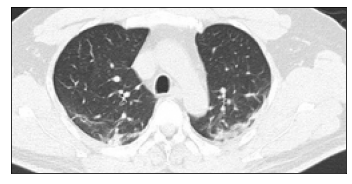

In [ ]:
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import random

dataset = ImageFolder("dataset/covid")#XRAY covid
#dataset = ImageFolder("dataset/eth")
sample_idx = random.randint(0, len(dataset) - 1)

# plotting the sample image
ax = plt.subplot(1,1,1)
plt.setp(ax, xticklabels=[])
plt.setp(ax, yticklabels=[])
plt.xticks([])
plt.yticks([])
plt.imshow(dataset[sample_idx][0])
plt.show()

To show the output of the transform, i.e. the corresponding spike-wave tensor, we plot each time-step separately for each feature until the 5th time-step. We also plot the accumulation of spikes over all of the features.

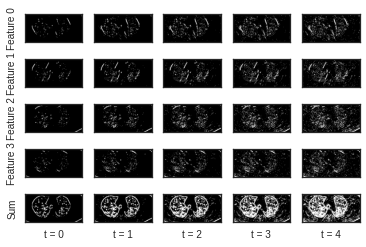

In [ ]:
import numpy as np

dataset = ImageFolder("dataset/covid", transform) # XRAY covid
#dataset = ImageFolder("dataset/eth", transform) # adding transform to the dataset
plt.style.use('seaborn-white')
plt_idx = 0
sw = dataset[sample_idx][0]
for f in range(4):
	for t in range(5):
		plt_idx += 1
		ax = plt.subplot(5, 5, plt_idx)
		plt.setp(ax, xticklabels=[])
		plt.setp(ax, yticklabels=[])
		if t == 0:
			ax.set_ylabel('Feature ' + str(f))
		plt.imshow(sw[t,f].numpy(),cmap='gray')
		if f == 3:
			ax = plt.subplot(5, 5, plt_idx + 5)
			plt.setp(ax, xticklabels=[])
			plt.setp(ax, yticklabels=[])
			if t == 0:
				ax.set_ylabel('Sum')
			ax.set_xlabel('t = ' + str(t))
			plt.imshow(sw[t].sum(dim=0).numpy(),cmap='gray')
plt.show()

To manage data loading, we use `DataLoader` provided by `torch.utils.data`. Here, we shuffle and split the whole dataset into two training (75%) and testing (25%) parts. Then, the corresponding indices will be given to data loaders.

In [ ]:
# splitting training and testing sets
from torchvision.datasets import ImageFolder
import random
dataset = ImageFolder("dataset/covid", transform)
indices = list(range(len(dataset)))
random.shuffle(indices)
split_point = int(0.25*len(indices))
train_indices = indices[:split_point]
test_indices = indices[split_point:]
print("Size of the training set:", len(train_indices))
print("Size of the  testing set:", len(test_indices))

Since the transform from image to spike-wave tensor is time-consuming and static, we use `SpykeTorch.utils.CacheDataset` to cache spike-wave tensors for each image. `CacheDataset` is a wrapper that can work with other PyTorch's `dataset` objects as well.

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler

dataset = utils.CacheDataset(dataset)
train_loader = DataLoader(dataset, sampler=SubsetRandomSampler(train_indices))
test_loader = DataLoader(dataset, sampler=SubsetRandomSampler(test_indices))

## 2. Layers C1 and S2
As mentioned before, C1 is a local pooling and S2 is a trainable convolutional layer. `SpykeTorch.snn` provides appropriate modules for each.

Layer C1 performs local pooling with window-size = 3 and stride = 2.

In [ ]:
import SpykeTorch.snn as snn

pool = snn.Pooling(kernel_size = 3, stride = 2)

Now we create a convolutional layer with 20 features and kernel-size equal to the size of the C1's output. Since Gabor filters are of size 3, each 64x64 input image shrinks to 62x62 after S1. Then by applying the pooling, the size of the C1's output will be 30x30.

In [ ]:
conv = snn.Convolution(in_channels=4, out_channels=20, kernel_size=30)

## 3. Unsupervised Learning
In this section, we show how to train and evaluate layer S2 using STDP. First, we assign STDP learning rule to layer S2:

In [ ]:
stdp = snn.STDP(conv_layer = conv, learning_rate = (0.05, -0.015))

### 3.1 Training
Each input spike-wave tensor (given by the data loader) will be passed through pooling (C1) and convolutional (S2) layers. The output of S2 denotes the trajectory of potentials over all of the time-steps. In order to convert them to spikes, we call `SpykeTorch.functional.fire` on the potentials with the desired threshold. When the output is ready, we find winners (here we have only one winner) to perform plasticity. `SpykeTorch.functional.get_k_winners` function, finds winner neurons first based on the earliest spike and then, based on the maximum potential. By providing input and output spike-wave and the potential tensors as well as the winners, STDP can be applied on layer S2.

In [ ]:
import time
start=time.time()
print("Starting Unsupervised Training ...")
for iter in range(2):
	print('\rIteration:', iter, end="")
	for data,_ in train_loader:
		for x in data:
			x = pool(x)
			p = conv(x)
			o, p = sf.fire(p, 20, return_thresholded_potentials=True)
			winners = sf.get_k_winners(p, kwta=1, inhibition_radius=0, spikes=o)
			stdp(x, p, o, winners)
print()
print("Unsupervised Training is Done.")
print(time.time()-start)

Starting Unsupervised Training ...
Iteration: 1
Unsupervised Training is Done.
361.11566162109375


### 3.2 Reconstructing Features
To reconstruct S2 features, one can use the provided functions in `SpykeTorch.visualization` module. `get_deep_feature` function receives the features extracted by the previous layer and generates the recunstructions for the current layer. It also outputs the accumulative stride until the current layer to be used when reconstructing the features of the next layer (if any).

In [ ]:
import SpykeTorch.visualization as vis
import torch
import matplotlib.pyplot as plt

feature = torch.stack([k() for k in kernels])
cstride = (1,1)
# C1 Features #
feature,cstride = vis.get_deep_feature(feature, cstride, (3, 3), (2, 2))
# S2 Features #
feature,cstride = vis.get_deep_feature(feature, cstride, (30,30), (1,1), conv.weight)

feature_idx = 0
for r in range(4):
    for c in range(5):
        ax = plt.subplot(4, 5, feature_idx+1)
        plt.xticks([])
        plt.yticks([])
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        plt.imshow(feature[feature_idx].numpy(),cmap='gray')
        feature_idx += 1
plt.show()

### 3.3 Evaluation
Since we performed unsupervised training, we need to use an external classifier to do the inference. Here, we use the linear SVM provided by `sklearn`. Before using the SVM, we need to prepare the training and testing data (network's output vectors). We extract two kinds of vectors from S2: (1) potentials, and (2) binary spikes.

**Training vectors:**

In [ ]:
import numpy as np
train_x_spike = []
train_x_pot = []
train_y = []
for data,targets in train_loader:
	for x,t in zip(data, targets):
		x = pool(x)
		p = conv(x)
		o = sf.fire(p, 20)
		train_x_spike.append(o.reshape(-1).cpu().numpy())
		train_x_pot.append(p.reshape(-1).cpu().numpy())
		train_y.append(t)
train_x_spike = np.array(train_x_spike)
train_x_pot = np.array(train_x_pot)
train_y = np.array(train_y)

In [ ]:
import json
json.dump("train_x_spike.json","w")

**Testing vectors:**

In [ ]:
test_x_spike = []
test_x_pot = []
test_y = []
for data,targets in test_loader:
	for x,t in zip(data, targets):
		x = pool(x)
		p = conv(x)
		o = sf.fire(p, 20)
		test_x_spike.append(o.reshape(-1).cpu().numpy())
		test_x_pot.append(p.reshape(-1).cpu().numpy())
		test_y.append(t)
test_x_spike = np.array(test_x_spike)
test_x_pot = np.array(test_x_pot)
test_y = np.array(test_y)

**Classifier:**

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

clf_spike_rf = RandomForestClassifier(max_depth=8, random_state=32)
clf_pot_rf = RandomForestClassifier(max_depth=8, random_state=32)
#clf_spike = LinearSVC(max_iter=100000)
#clf_pot = LinearSVC(max_iter=100000)
#clf_spike.fit(train_x_spike, train_y)
#clf_pot.fit(train_x_pot, train_y)
clf_spike_rf.fit(train_x_spike, train_y)
clf_pot_rf.fit(train_x_pot, train_y)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=32, verbose=0,
                       warm_start=False)

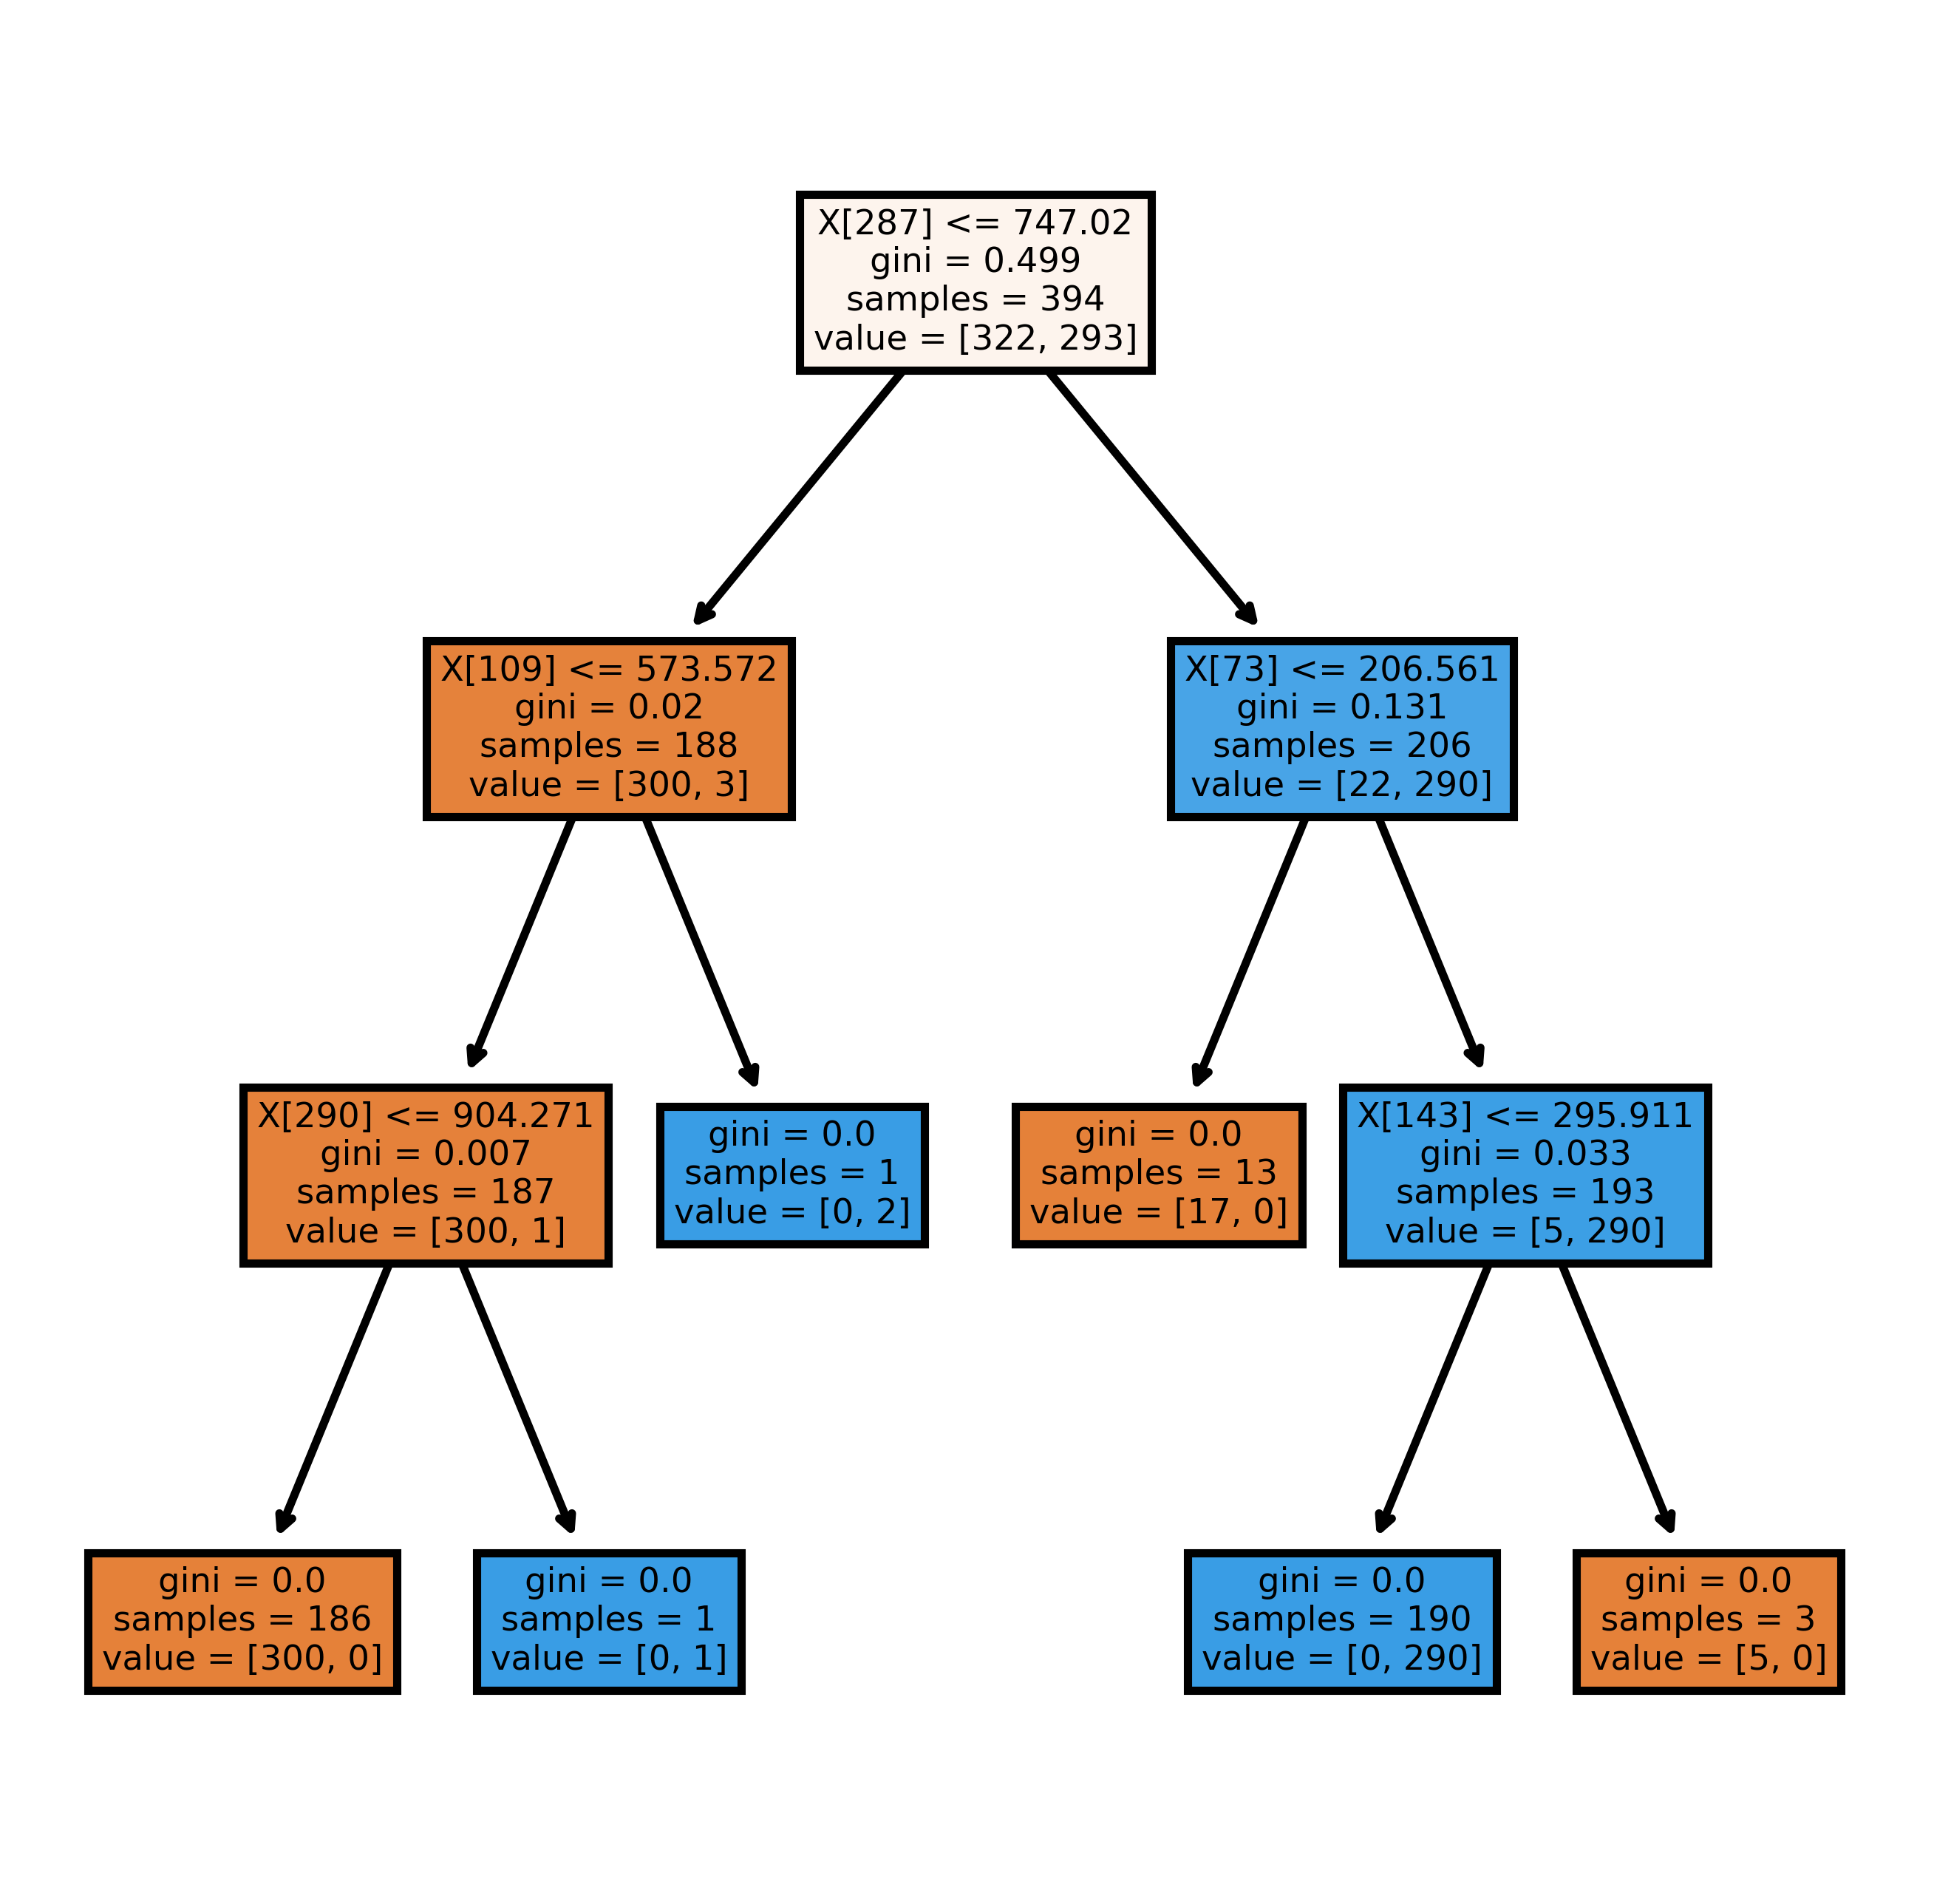

In [ ]:
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(clf_pot_rf.estimators_[0],
               filled = True)

fig.savefig('rf_individualtree.png')

**Inference:**

In [ ]:
from sklearn.metrics import classification_report as cfr
#predict_spike = clf_spike.predict(test_x_spike)
#predict_pot = clf_pot.predict(test_x_pot)
predict_spike = clf_spike_rf.predict(test_x_spike)
predict_pot = clf_pot_rf.predict(test_x_pot)
print(cfr(test_y,predict_spike))
print(cfr(test_y,predict_pot))
error_spike = np.abs(test_y - predict_spike).sum()
error_pot = np.abs(test_y - predict_pot).sum()
print("    Spike-based error:", error_spike/len(predict_spike))
print("Potential-based error:", error_pot/len(predict_pot))

              precision    recall  f1-score   support

           0       0.63      0.92      0.74        95
           1       0.88      0.53      0.66       110

    accuracy                           0.71       205
   macro avg       0.75      0.72      0.70       205
weighted avg       0.76      0.71      0.70       205

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        95
           1       0.99      1.00      1.00       110

    accuracy                           1.00       205
   macro avg       1.00      0.99      1.00       205
weighted avg       1.00      1.00      1.00       205

    Spike-based error: 0.2926829268292683
Potential-based error: 0.004878048780487805
